In [1]:
import numpy as np
import libaarhusxyz
def read_em_data_from_dat_xyz(em_data, name_gate_times='gate times', dat_type='dat'):
    gate_times = np.array(em_data.info[name_gate_times])
    df_em = em_data.flightlines
    group_em = df_em.groupby('record')
    records = list(group_em.groups.keys())
    df_em_collar = group_em[['line_no','utmx','utmy','timestamp','elevation','alt','tilt']].mean()

    dat_names = ['data_{:d}'.format(ii+1) for ii in range(gate_times.size)]
    df_em[dat_names] = em_data.layer_data['data']
    if dat_type == 'dat':    
        dat_std_names = ['datastd_{:d}'.format(ii+1) for ii in range(gate_times.size)]
        df_em[dat_std_names] = em_data.layer_data['datastd']    

    em_data_nan = em_data.layer_data['data']
    em_data_nan = em_data_nan.replace(9999, np.nan)
    n_ch1_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=1).mean())
    n_ch2_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=1).mean())
    print (f"Active # of channels: Ch1={n_ch1_active:.0f}, Ch2={n_ch2_active:.0f}")

    inds_lm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=0) > 0.
    inds_hm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=0) > 0.

    data_lm = []
    data_hm = []
    if dat_type == 'dat':
        datastd_lm = []
        datastd_hm = []
    records_inv = []
    for i_record in records:
        df_tmp = group_em.get_group(i_record)
        values = df_tmp[dat_names].values
        if dat_type == 'dat':
            values_std = df_tmp[dat_std_names].values
        if df_tmp.shape[0] == 2:
            i_lm = np.argwhere(df_tmp['segment'].values==1)[0][0]                
            i_hm = np.argwhere(df_tmp['segment'].values==2)[0][0]
            data_lm.append(values[i_lm,inds_lm])
            data_hm.append(values[i_hm,inds_hm])
            if dat_type == 'dat':
                datastd_lm.append(values_std[i_lm,inds_lm])
                datastd_hm.append(values_std[i_hm,inds_hm])        
            records_inv.append(i_record)
    data_lm = np.vstack(data_lm)
    data_hm = np.vstack(data_hm)
    if dat_type == 'dat':
        datastd_lm = np.vstack(datastd_lm)
        datastd_hm = np.vstack(datastd_hm)
    records_inv = np.hstack(records_inv)
    df_em_inv = df_em_collar.loc[records_inv]
    times_lm_inv = gate_times[inds_lm]
    times_hm_inv = gate_times[inds_hm]    

    ch1_names = ['dbdt_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
    ch2_names = ['dbdt_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]
    if dat_type == 'dat':    
        std_ch1_names = ['dbdt_std_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
        std_ch2_names = ['dbdt_std_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]    

    df_em_inv[ch1_names] = data_lm
    df_em_inv[ch2_names] = data_hm
    if dat_type == 'dat':    
        df_em_inv[std_ch1_names] = datastd_lm
        df_em_inv[std_ch2_names] = datastd_hm
    
    meta_data_dict = {}
    meta_data_dict['ch1_names'] = ch1_names
    meta_data_dict['ch2_names'] = ch2_names
    if dat_type == 'dat':    
        meta_data_dict['std_ch1_names'] = std_ch1_names
        meta_data_dict['std_ch2_names'] = std_ch1_names
    meta_data_dict['ch1_times'] = times_lm_inv
    meta_data_dict['ch2_times'] = times_hm_inv
    df_em_inv = df_em_inv.replace(9999, np.nan)
    return df_em_inv, meta_data_dict

In [3]:
fname = "../salinas_2017/MCWD3_SCI1i_MOD_dat.xyz"
aem_data = libaarhusxyz.XYZ(fname)
df_em_inv, meta_data_dict = read_em_data_from_dat_xyz(aem_data, name_gate_times='gate times (s)')

Active # of channels: Ch1=18, Ch2=25


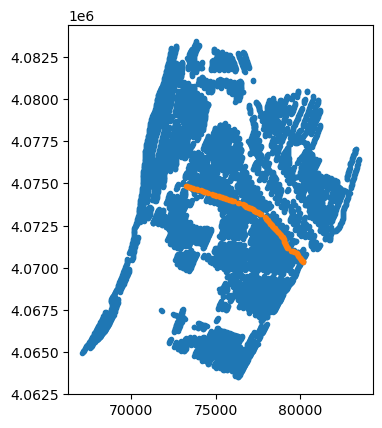

In [4]:
import matplotlib.pyplot as plt
## Pull out required columns from df_em_inv
i_start_lm = 1
i_start_hm = 0
line_all = df_em_inv['line_no'].values
topo_all = df_em_inv[['utmx', 'utmy', 'elevation']].values
line_uniq = np.unique(line_all)
i_line = 4
inds_line = line_all==line_uniq[i_line]

line = df_em_inv['line_no'].values[inds_line]
topo = df_em_inv[['utmx', 'utmy', 'elevation']].values[inds_line, :]
source_heights = df_em_inv['alt'].values[inds_line]
data_lm = df_em_inv[meta_data_dict['ch1_names']].values[inds_line, i_start_lm:]
data_hm = df_em_inv[meta_data_dict['ch2_names']].values[inds_line, i_start_hm:]
data_std_lm = df_em_inv[meta_data_dict['std_ch1_names']].values[inds_line, i_start_lm:]
data_std_hm = df_em_inv[meta_data_dict['std_ch2_names']].values[inds_line, i_start_hm:]
n_sounding = len(line)
times_lm = meta_data_dict['ch1_times'][i_start_lm:]
times_hm = meta_data_dict['ch2_times'][i_start_hm:]
plt.plot(topo_all[:,0], topo_all[:,1], '.')
plt.plot(topo[:,0], topo[:,1], '.')
plt.gca().set_aspect(1)

In [38]:
from SimPEG.electromagnetics.utils.em1d_utils import get_vertical_discretization
thicknesses = get_vertical_discretization(30, 2., 1.08)
hz = np.r_[thicknesses, thicknesses[-1]]

>> Depth from the surface to the base of the bottom layer is 226.6m


In [47]:
n_time = times_lm.size + times_hm.size
n_layer = len(hz)
relative_error = 0.03
noise_floor = 1e-14
ignore_value = 9999.
dobs = -np.hstack((data_lm, data_hm)).flatten()
dobs[np.isnan(dobs)] = ignore_value
inds_active_dobs = dobs != 9999.
uncertainties = relative_error*np.abs(dobs) + noise_floor
uncertainties[~inds_active_dobs] = np.inf

In [48]:
import dill
inversion_results = dill.load(open("inversion_results.pik", "rb"))

In [49]:
inversion_iterations = list(inversion_results.keys())

In [84]:
inversion_iterations

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [72]:
iteration = 10
dpred_inv = -(inversion_results[iteration]['dpred'])
dpred_inv[~inds_active_dobs] = np.nan
DPRED = dpred_inv.reshape((n_sounding, n_time))
dpred_lm = DPRED[:,:len(times_lm)]
dpred_hm = DPRED[:,len(times_lm):]
m = inversion_results[iteration]['m']

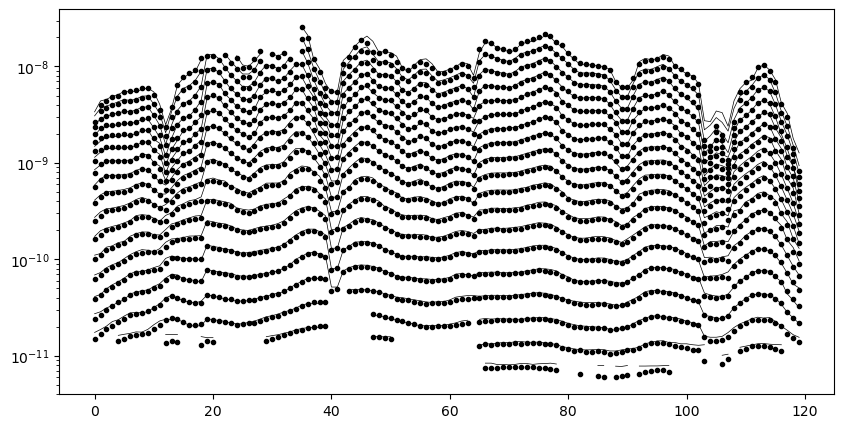

In [73]:
fig =plt.figure(figsize=(10, 5))
_ = plt.semilogy(data_lm, 'k', lw=0.5)
_ = plt.semilogy(dpred_lm, 'k.')

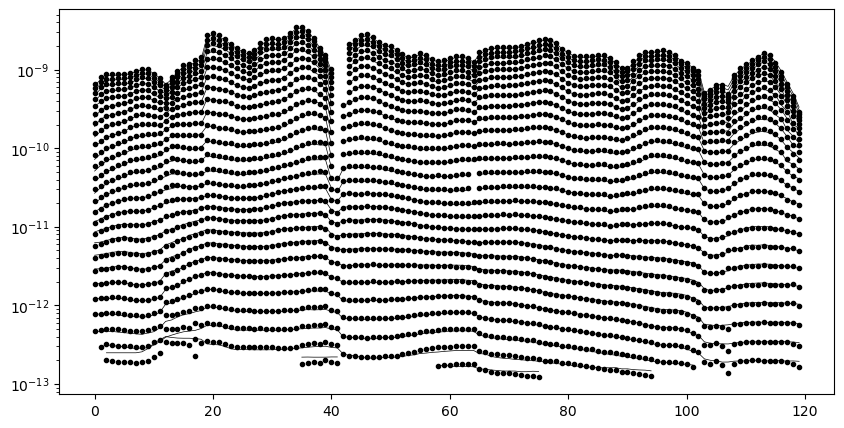

In [74]:
fig =plt.figure(figsize=(10, 5))
_ = plt.semilogy(data_hm, 'k', lw=0.5)
_ = plt.semilogy(dpred_hm, 'k.')

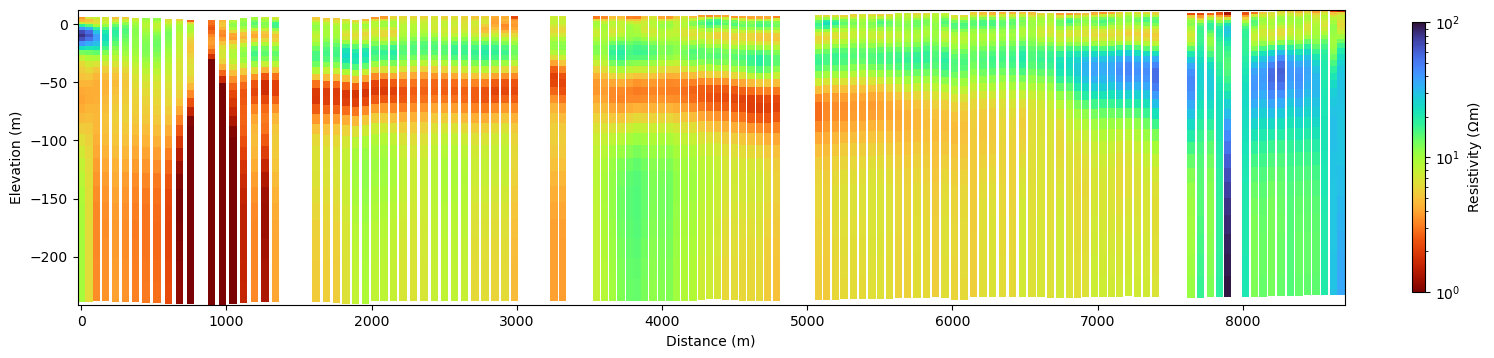

In [83]:
from SimPEG.electromagnetics.utils.em1d_utils import Stitched1DModel
iteration = 10
m = inversion_results[iteration]['m']

rho = 1./np.exp(m)
model = Stitched1DModel(
    hz=hz,
    line=line, 
    topography=topo,
    physical_property=rho,
    n_layer=n_layer
)
out = model.plot_section(i_line=0, cmap='turbo_r', clim=(1, 100), x_axis='distance', dx=25, aspect=8, alpha=1)
ax = out[1]
cb = out[2]
cb.set_label("Resistivity ($\Omega$m)")